In [1]:
import pl_interactions as pli

import mdtraj as mdt
import nglview as nv
import numpy as np
from matplotlib.colors import to_rgb
from rdkit import Chem

# Visualize the binding site of protein-ligand complex

In [2]:
def extract_chain(traj, chains):
    """ Extract chains from a trajectory

        Parameters
        ----------
        traj: mdtraj.trajectory

        chains: list[int]

        Returns
        -------
        new_traj: mdtraj.Trajectory

    """
    topology = traj.topology
    return traj.atom_slice(
        [atom.index for atom in topology.atoms if (atom.residue.chain.index in chains)]
    )

In [3]:
def add_sphere_to_view(view, center, radius):
    """ Add a sphere to a view. """
    color = '#B03A2E'
    n_components = len(view._ngl_component_ids)
    view.shape.add_sphere(center.tolist(), to_rgb(color), radius, "sphere")
    view.update_representation(component=n_components, repr_index=0, opacity=0.3)

In [4]:
traj_all_chains = mdt.load("../../datasets/ligand-receptor/test_cases/eralpha/1qku/1qku.pdb")
traj = extract_chain(traj_all_chains, [0, 3])
view = nv.show_mdtraj(traj)

In [5]:
ligand = extract_chain(traj_all_chains, [3])
nv.show_mdtraj(ligand)

NGLWidget()

In [6]:
traj.save_pdb("./data/er_alpha/er_alpha_A_chain.pdb")
ligand.save_pdb("./data/er_alpha/estradiol.pdb")

In [7]:
print(pli.find_ligands_in_traj(traj))

['EST:B']


In [8]:
ligand_id = "EST:B"
centroid = pli.ligand_centroid(traj, ligand_id) * 10 # convert to angstroms
extent = pli.ligand_maximum_extent(traj, ligand_id) * 10

In [9]:
bs_site = extent + 8.5

In [10]:
add_sphere_to_view(view, centroid, bs_site)
view.representations = [
     {"type": "ball+stick", 
      "params": {
          "sele": "protein",
          "color": "residueindex"
      }},
    {"type": "ball+stick", 
     "params": {
         "sele": "( not polymer or hetero ) and not ( water or ion )"
    }}
]
view

NGLWidget()

## Extract binding site
Extract binding site to a new trajectory for visualization purposes

In [11]:
BS_DIST = 5.0  # in angstroms


def get_binding_site_atoms_indices(lig_center, lig_max_extent, coords):
    """ Get the indices of all the atoms that belong to the binding site.

        Parameters
        ----------
        lig_center : np.array of shape (3,)
        lig_max_extent : float
        coords: np.array of shape(n_atoms, 3)

        Returns
        -------
        bs_indices: list[int]
    """
    bs_cutoff = lig_max_extent + BS_DIST
    distance = np.sqrt(np.sum(np.power(coords - lig_center, 2), axis=1))
    return np.where(distance <= bs_cutoff)[0]

In [12]:
bs_indices = get_binding_site_atoms_indices(centroid, extent, traj.xyz[0] * 10)
bs_indices.shape

(287,)

In [13]:
bs_traj = traj.atom_slice(bs_indices)

# Some of the rsidue

In [14]:
bs_view = nv.show_mdtraj(bs_traj)
bs_view.representations = [
     {"type": "ball+stick", 
      "params": {
          "sele": "protein",
      }},
    {"type": "ball+stick", 
     "params": {
         "sele": "( not polymer or hetero ) and not ( water or ion )",
         "color": "blue"
    }}
]
bs_view

NGLWidget()

In [15]:
print(f"Num chains {bs_traj.n_chains}")
print(f"Num residues {bs_traj.n_residues}")
print(f"Num atoms {bs_traj.n_atoms}")

Num chains 2
Num residues 53
Num atoms 287


### Removing incomplete residues from the binding site

When we extracted the binding site, some of the residues lost some of their atoms and they are 
incomplete. We will remove this residues.

In [16]:
bs_df, _ = bs_traj.topology.to_dataframe()

LEU 540 is an example of a residue that lost part of its atoms

In [17]:
bs_df[bs_df["resSeq"] == 540]

,serial,name,element,resSeq,resName,chainID,segmentID
259,1898,CA,C,540,LEU,0,
260,1900,O,O,540,LEU,0,
261,1901,CB,C,540,LEU,0,
262,1902,CG,C,540,LEU,0,
263,1903,CD1,C,540,LEU,0,
264,1904,CD2,C,540,LEU,0,


In [18]:
traj_df, _ =  traj.topology.to_dataframe()

In [19]:
traj_df[traj_df["resSeq"] == 540]

,serial,name,element,resSeq,resName,chainID,segmentID
1896,1897,N,N,540,LEU,0,
1897,1898,CA,C,540,LEU,0,
1898,1899,C,C,540,LEU,0,
1899,1900,O,O,540,LEU,0,
1900,1901,CB,C,540,LEU,0,
1901,1902,CG,C,540,LEU,0,
1902,1903,CD1,C,540,LEU,0,
1903,1904,CD2,C,540,LEU,0,


In [20]:
bs_res_seq = bs_df["resSeq"].unique()
bs_res_seq

array([342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354,
       357, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 394,
       402, 403, 404, 405, 408, 410, 418, 420, 421, 424, 425, 428, 517,
       518, 519, 520, 521, 522, 523, 524, 525, 526, 528, 534, 540, 544,
       600])

In [21]:
incomplete_residues = []
for res in bs_res_seq:
    res_bs = bs_df[bs_df["resSeq"] == res]
    res_traj = traj_df[traj_df["resSeq"] == res]
    if len(res_bs) != len(res_traj):
        incomplete_residues.append(res)

print(f"{len(incomplete_residues)} incomplete residues")

33 incomplete residues


In [22]:
print(incomplete_residues)

[342, 345, 348, 351, 352, 353, 354, 357, 382, 383, 385, 386, 389, 390, 392, 394, 402, 403, 405, 408, 410, 418, 420, 428, 517, 519, 520, 523, 526, 528, 534, 540, 544]


In [23]:
atoms_bs = []
for atom in bs_traj.topology.atoms:
    
    if atom.residue.resSeq not in incomplete_residues:
        atoms_bs.append(atom.index)

bs_traj = bs_traj.atom_slice(atoms_bs)
bs_traj

<mdtraj.Trajectory with 1 frames, 166 atoms, 20 residues, and unitcells at 0x7f28d80e1e90>

In [24]:
bs_view = nv.show_mdtraj(bs_traj)
bs_view.representations = [
     {"type": "ball+stick", 
      "params": {
          "sele": "protein",
      }},
    {"type": "ball+stick", 
     "params": {
         "sele": "( not polymer or hetero ) and not ( water or ion )",
         "color": "blue"
    }}
]
bs_view

NGLWidget()

In [25]:
bs_traj.save_pdb("./data/er_alpha/binding_site.pdb")

In [27]:
bs_mol = Chem.MolFromPDBFile("./data/er_alpha/binding_site.pdb")
bs_mol.GetNumAtoms()

166

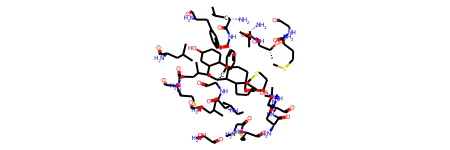

In [28]:
bs_mol